In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
from concurrent.futures import ThreadPoolExecutor
import os
from data_generation import generate_gaussian_noises_dict, generate_sparse_response, generate_perturbed_response

import warnings
warnings.filterwarnings('ignore')

In [2]:
# TODO: Hyperparameters search for omp

##* Data Generation
##* N (columns of dictionary) = 10k
##* d (dimension of signal) = 300, 600, 900, 1200, 1500, 2000
##* X_{ij} \sim N(0, \frac{1}{n}) (The same as N(0,1) them normalize)
##* m (sparse level) = 20, 40, 80

##* Noise level = 0.01, 0.05, 0.1, 0.2, 0.5

N = 1000
d = 400
m = 40
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.5]
trial_num = 10
cv_num = 5

In [3]:
##! Task 1: Given signal, dictionary, sparsity level and noise level, use testset (10% of the whole signal) to find the best K(depth) for omp

from data_generation import GaussianDataGenerator

seed = 0
Data_Geneartor = GaussianDataGenerator(N, d, m, 0.05, seed)

true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()

In [4]:
dictionary.shape

(400, 1000)

In [5]:
def cv_split(true_signal, dictionary, cv_num):
    true_signal = true_signal.ravel()
    # true_signal is (1200, 1) and dictionary is (1200, 10000), cv both signal and dictionary by rows
    cv_signal = np.split(true_signal, cv_num)
    cv_dictionary = np.split(dictionary, cv_num)
    # Get the list of train and test set
    cv_res = []
    for i in range(cv_num):
        train_signal = np.concatenate(cv_signal[:i] + cv_signal[i + 1:], axis = 0)
        train_dictionary = np.concatenate(cv_dictionary[:i] + cv_dictionary[i + 1:], axis=0)
        test_signal = cv_signal[i]
        test_dictionary = cv_dictionary[i]
        cv_res.append((train_signal, train_dictionary, test_signal, test_dictionary))
    return cv_res

In [6]:
# We need a OMP class to do the cross validation and it need a fit and score function

def cal_cv_error(algorithm, cv_num, signal, dictionary):
    cv_res = cv_split(signal, dictionary, cv_num)
    error_lst = []
    for i in range(cv_num):
        train_signal, train_dictionary, test_signal, test_dictionary = cv_res[i]
        algorithm.fit(train_signal, train_dictionary)
        error_lst.append(algorithm.score(test_signal, test_dictionary))
    return np.mean(error_lst)

In [7]:
from algorithms import OMP

cal_cv_error(OMP(10), 10, perturbed_signal, dictionary)

Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP
Singular matrix encountered in OMP


0.253225794217966

In [8]:
##! Task 2: Relationship between best K and noise level (std)

def cv_best_K(signal, dictionary, cv_num, K_lst):
    K_cv_error = []
    for K in K_lst:
        OMP_tmp = OMP(K, ignore_warning=True)
        K_cv_error.append(cal_cv_error(OMP_tmp, cv_num, signal, dictionary))
    lowest_error = np.min(K_cv_error)
    lowest_error_K = K_lst[np.argmin(K_cv_error)]
    return lowest_error, lowest_error_K

cv_best_K(perturbed_signal, dictionary, 5, np.arange(2, 22, 2))

(0.24133572863858058, 20)

In [12]:
# Improvement: Save the result to a file

if not os.path.exists('./memory'):
    os.mkdir('./memory')

def cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, K_lst, trial_num):
    noise_level_best_K = []
    for noise_level in noise_level_lst:
        print("Cross validating K under noise level: ", noise_level)
        trials_best_K_tmp = []
        for trial in range(trial_num):
            Data_Geneartor = GaussianDataGenerator(N, d, m, noise_level, trial)
            true_signal, dictionary, true_indices, true_coefficients, perturbed_signal = Data_Geneartor.shuffle()
            lowest_error, lowest_error_K = cv_best_K(perturbed_signal, dictionary, cv_num, K_lst)
            trials_best_K_tmp.append(lowest_error_K)
        noise_level_best_K.append(np.mean(trials_best_K_tmp))
        print("Best K for noise level: ", noise_level, " is: ", np.mean(trials_best_K_tmp))
    return noise_level_best_K

N = 1000
d = 1000
m = 40
noise_level_lst = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
trial_num = 10
cv_num = 10

bestK_each_noise = cv_best_K_noise_level_multi_trial(N, d, m, noise_level_lst, cv_num, np.arange(2, 101, 2), trial_num)

Cross validating K under noise level:  0
Best K for noise level:  0  is:  31.8
Cross validating K under noise level:  0.01
Best K for noise level:  0.01  is:  41.2
Cross validating K under noise level:  0.05
Best K for noise level:  0.05  is:  19.6
Cross validating K under noise level:  0.1
Best K for noise level:  0.1  is:  13.2
Cross validating K under noise level:  0.2
Best K for noise level:  0.2  is:  7.4
Cross validating K under noise level:  0.3
Best K for noise level:  0.3  is:  10.2
Cross validating K under noise level:  0.4
Best K for noise level:  0.4  is:  10.8
Cross validating K under noise level:  0.5
Best K for noise level:  0.5  is:  18.2


Text(0, 0.5, 'Best K')

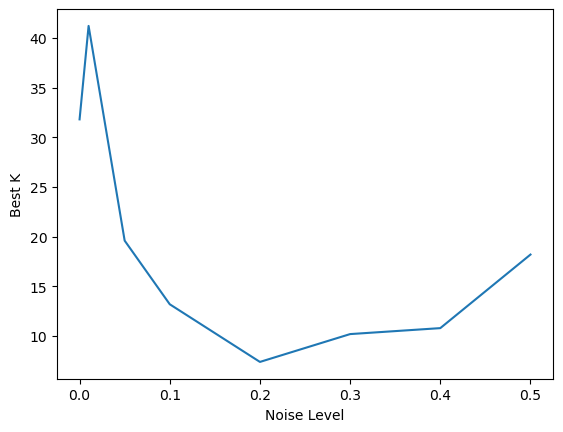

In [14]:
from matplotlib import pyplot as plt

plt.plot(noise_level_lst, bestK_each_noise)
plt.xlabel("Noise Level")
plt.ylabel("Best K")

In [ ]:
##! Task 3: Relationship between Test Error and noise level (std)

